In [25]:
# Homework 2
# Group 18

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from PIL import Image, ImageEnhance
import random

In [27]:
# Set Constants
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

LATENT_DIM = 256
BATCH_SIZE = 32
LEARNING_RATE = 1 * 1e-3
NUM_EPOCHS = 30
DROPOUT_RATE = 0
WEIGHT_DECAY = 1e-5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
# Loading Data
keywords = ['face']
dataset = load_dataset('valhalla/emoji-dataset')['train']
imgs = []
for data in dataset:
    title = data['text'].lower()
    if any (k in title for k in keywords):
        img = data['image'].convert('RGB').resize((64, 64), Image.LANCZOS)
        imgs.append(img)
X = np.stack(imgs)
print(X.shape)

(204, 64, 64, 3)


In [29]:
# Data augmentation
original_size = len(imgs)
train_size_target = 600
val_size_target = 200
test_size_target = 200
total_target = train_size_target + val_size_target + test_size_target

indices = np.arange(len(imgs))
np.random.shuffle(indices)
train_size = int(0.6 * original_size)
val_size = int(0.2 * original_size)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]
train_imgs_orig = [imgs[i] for i in train_indices]
val_imgs_orig = [imgs[i] for i in val_indices]
test_imgs_orig = [imgs[i] for i in test_indices]

def augment_image(img):
    augmented = []
    augmented.append(img)
    augmented.append(img.rotate(30, fillcolor=(255, 255, 255)))
    augmented.append(img.rotate(-30, fillcolor=(255, 255, 255)))
    augmented.append(ImageEnhance.Brightness(img).enhance(random.uniform(0.8, 1.2)))
    augmented.append(ImageEnhance.Contrast(img).enhance(random.uniform(0.8, 1.2)))
    return augmented

def augment_dataset(imgs, target_size):
    augmented = []
    imgs_shuffled = imgs.copy()
    random.shuffle(imgs_shuffled)
    while(len(augmented)) < target_size:
        for img in imgs_shuffled:
            if len(augmented) >= target_size:
                break
            aug_imgs = augment_image(img)
            augmented.extend(aug_imgs)
    return augmented

train_imgs = augment_dataset(train_imgs_orig, train_size_target)
val_imgs = augment_dataset(val_imgs_orig, val_size_target)
test_imgs = augment_dataset(test_imgs_orig, test_size_target)
random.shuffle(train_imgs)
random.shuffle(val_imgs)
random.shuffle(test_imgs)

transform = T.Compose([
    T.ToTensor(),
])
X_train = torch.stack([transform(img) for img in train_imgs])
X_val = torch.stack([transform(img) for img in val_imgs])
X_test = torch.stack([transform(img) for img in test_imgs])
train_dataset = TensorDataset(X_train, X_train)
val_dataset = TensorDataset(X_val, X_val)
test_dataset = TensorDataset(X_test, X_test)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [30]:
# define model
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim = LATENT_DIM):
        super(ConvAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(DROPOUT_RATE),


            nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(DROPOUT_RATE),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(DROPOUT_RATE),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Dropout2d(DROPOUT_RATE),
        )

        self.latent_dim = latent_dim
        self.flatten = nn.Flatten()
        self.fc_encode = nn.Linear(256 * 4 * 4, self.latent_dim)
        self.fc_decode = nn.Linear(self.latent_dim, (256 * 4 * 4))
        self.unflatten = nn.Unflatten(1, (256 ,4 ,4))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Dropout2d(DROPOUT_RATE),

            nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(DROPOUT_RATE),

            nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(DROPOUT_RATE),

            nn.ConvTranspose2d(32, 3, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        z = self.fc_encode(x)
        return z
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = self.unflatten(x)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

In [31]:
# Train the model
model = ConvAutoencoder(latent_dim = LATENT_DIM).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc = f"Epoch {epoch + 1}/{NUM_EPOCHS}")):
        data = data.to(DEVICE)
        optimizer.zero_grad()
        recon, _ = model(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(DEVICE)
            recon, _ = model(data)
            loss = criterion(recon, data)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f"Train Loss : {train_loss:.6f}, Val Loss : {val_loss:.6f}")

model.eval()
test_loss = 0
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(DEVICE)
        recon, _ = model(data)
        loss = criterion(recon, data)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.6f}")

Epoch 1/30: 100%|██████████| 19/19 [00:01<00:00,  9.83it/s]


Train Loss : 0.113522, Val Loss : 0.103060


Epoch 2/30: 100%|██████████| 19/19 [00:01<00:00, 10.47it/s]


Train Loss : 0.064119, Val Loss : 0.054579


Epoch 3/30: 100%|██████████| 19/19 [00:01<00:00, 10.16it/s]


Train Loss : 0.044476, Val Loss : 0.038275


Epoch 4/30: 100%|██████████| 19/19 [00:02<00:00,  9.49it/s]


Train Loss : 0.034516, Val Loss : 0.030941


Epoch 5/30: 100%|██████████| 19/19 [00:02<00:00,  9.45it/s]


Train Loss : 0.028815, Val Loss : 0.026661


Epoch 6/30: 100%|██████████| 19/19 [00:01<00:00, 10.23it/s]


Train Loss : 0.025238, Val Loss : 0.025584


Epoch 7/30: 100%|██████████| 19/19 [00:01<00:00, 10.12it/s]


Train Loss : 0.022693, Val Loss : 0.023864


Epoch 8/30: 100%|██████████| 19/19 [00:01<00:00, 10.27it/s]


Train Loss : 0.020386, Val Loss : 0.021848


Epoch 9/30: 100%|██████████| 19/19 [00:01<00:00,  9.93it/s]


Train Loss : 0.018453, Val Loss : 0.021877


Epoch 10/30: 100%|██████████| 19/19 [00:01<00:00, 10.10it/s]


Train Loss : 0.017958, Val Loss : 0.023582


Epoch 11/30: 100%|██████████| 19/19 [00:01<00:00, 10.14it/s]


Train Loss : 0.017364, Val Loss : 0.020304


Epoch 12/30: 100%|██████████| 19/19 [00:01<00:00, 10.23it/s]


Train Loss : 0.015946, Val Loss : 0.019782


Epoch 13/30: 100%|██████████| 19/19 [00:01<00:00, 10.26it/s]


Train Loss : 0.014666, Val Loss : 0.021012


Epoch 14/30: 100%|██████████| 19/19 [00:01<00:00,  9.84it/s]


Train Loss : 0.013820, Val Loss : 0.018684


Epoch 15/30: 100%|██████████| 19/19 [00:01<00:00, 10.08it/s]


Train Loss : 0.013065, Val Loss : 0.018540


Epoch 16/30: 100%|██████████| 19/19 [00:01<00:00, 10.01it/s]


Train Loss : 0.012762, Val Loss : 0.018187


Epoch 17/30: 100%|██████████| 19/19 [00:01<00:00, 10.18it/s]


Train Loss : 0.011864, Val Loss : 0.017773


Epoch 18/30: 100%|██████████| 19/19 [00:01<00:00, 10.06it/s]


Train Loss : 0.011641, Val Loss : 0.017903


Epoch 19/30: 100%|██████████| 19/19 [00:01<00:00, 10.13it/s]


Train Loss : 0.011235, Val Loss : 0.017336


Epoch 20/30: 100%|██████████| 19/19 [00:01<00:00, 10.09it/s]


Train Loss : 0.010573, Val Loss : 0.018067


Epoch 21/30: 100%|██████████| 19/19 [00:01<00:00,  9.97it/s]


Train Loss : 0.010304, Val Loss : 0.016916


Epoch 22/30: 100%|██████████| 19/19 [00:01<00:00, 10.21it/s]


Train Loss : 0.009898, Val Loss : 0.017224


Epoch 23/30: 100%|██████████| 19/19 [00:01<00:00, 10.22it/s]


Train Loss : 0.009155, Val Loss : 0.016710


Epoch 24/30: 100%|██████████| 19/19 [00:01<00:00, 10.19it/s]


Train Loss : 0.009026, Val Loss : 0.017596


Epoch 25/30: 100%|██████████| 19/19 [00:01<00:00, 10.17it/s]


Train Loss : 0.008589, Val Loss : 0.016502


Epoch 26/30: 100%|██████████| 19/19 [00:01<00:00, 10.22it/s]


Train Loss : 0.008341, Val Loss : 0.016674


Epoch 27/30: 100%|██████████| 19/19 [00:01<00:00, 10.22it/s]


Train Loss : 0.007875, Val Loss : 0.016665


Epoch 28/30: 100%|██████████| 19/19 [00:01<00:00,  9.85it/s]


Train Loss : 0.007810, Val Loss : 0.016658


Epoch 29/30: 100%|██████████| 19/19 [00:01<00:00, 10.03it/s]


Train Loss : 0.007363, Val Loss : 0.016698


Epoch 30/30: 100%|██████████| 19/19 [00:01<00:00, 10.08it/s]


Train Loss : 0.007641, Val Loss : 0.016292
Test Loss: 0.017247


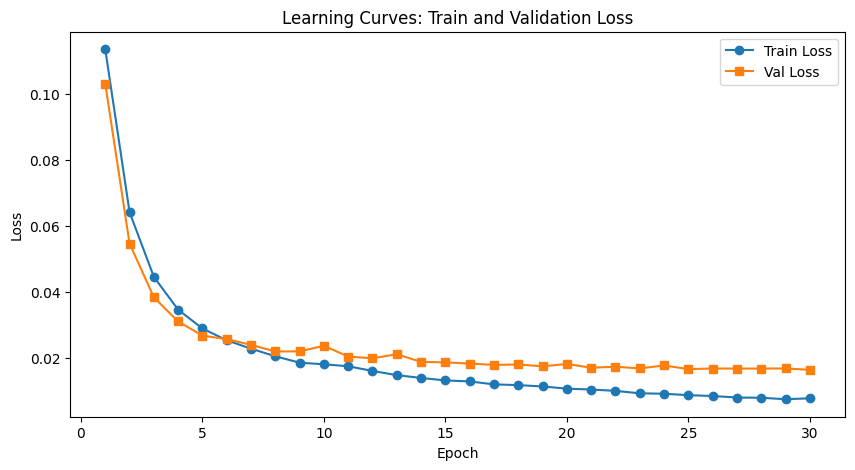

In [32]:
plt.figure(figsize = (10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label = 'Train Loss', marker = 'o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label = 'Val Loss', marker = 's')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Learning Curves: Train and Validation Loss")
plt.savefig('q1_learning_curves.png', dpi = 300, bbox_inches = 'tight')
plt.show()

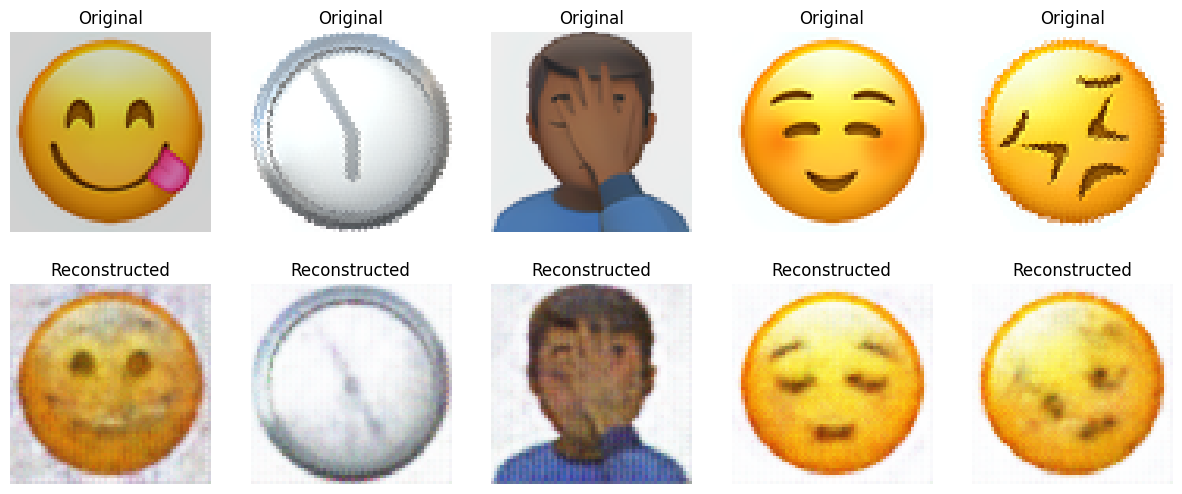

In [33]:
model.eval()
with torch.no_grad():
    sample_data = X_test[:5].to(DEVICE)
    recon_data, _ = model(sample_data)
    sample_data = sample_data.cpu().numpy()
    recon_data = recon_data.cpu().numpy()
    fig, axes = plt.subplots(2, 5, figsize = (15, 6))
    for i in range(5):
        axes[0, i].imshow(np.transpose(sample_data[i], (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')
        axes[1, i].imshow(np.transpose(recon_data[i], (1, 2, 0)))
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstructed')
    plt.savefig('q1_reconstructions.png', dpi = 300, bbox_inches = 'tight')
    plt.show()

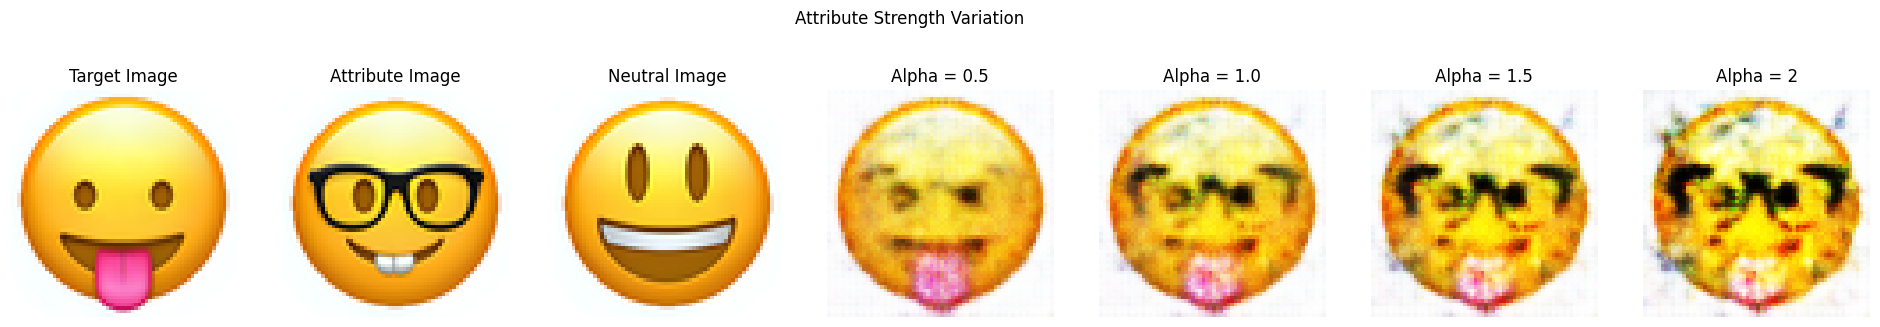

In [34]:
# Question 2
keywords = ['face']
all_emojis = []
for data in dataset:
    title = data['text'].lower()
    if any(k in title for k in keywords):
        img = data['image'].convert('RGB').resize((64, 64), Image.LANCZOS)
        all_emojis.append({
            'title': title,
            'image': img
        })
def find_emoji_by_keyword(keyword, emojis):
    matches = []
    for i, emoji in enumerate(emojis):
        if keyword.lower() in emoji['title'].lower():
            matches.append((i, emoji['title']))
    return matches

ATTRIBUTE_KEYWORD = 'nerd'
NEUTRAL_KEYWORD = 'smiling'
TARGET_KEYWORD = 'tongue'
ATTRIBUTE_MATCHES = find_emoji_by_keyword(ATTRIBUTE_KEYWORD, all_emojis)
NEUTRAL_MATCHES = find_emoji_by_keyword(NEUTRAL_KEYWORD, all_emojis)
TARGET_MATCHES = find_emoji_by_keyword(TARGET_KEYWORD, all_emojis)
ATTRIBUTE_IDX = ATTRIBUTE_MATCHES[0][0]
NEUTRAL_IDX = NEUTRAL_MATCHES[0][0]
TARGET_IDX = TARGET_MATCHES[0][0]
ATTRIBUTE_IMAGE = all_emojis[ATTRIBUTE_IDX]['image']
NEUTRAL_IMAGE = all_emojis[NEUTRAL_IDX]['image']
TARGET_IMAGE = all_emojis[TARGET_IDX]['image']

transform = T.ToTensor()
attribute_tensor = transform(ATTRIBUTE_IMAGE).unsqueeze(0).to(DEVICE)
neutral_tensor = transform(NEUTRAL_IMAGE).unsqueeze(0).to(DEVICE)
target_tensor = transform(TARGET_IMAGE).unsqueeze(0).to(DEVICE)

alphas = [0.5, 1.0, 1.5, 2]
fig, axes = plt.subplots(1, len(alphas) + 3, figsize = (4 * (len(alphas) + 2), 4))
axes[0].imshow(TARGET_IMAGE)
axes[0].set_title('Target Image')
axes[0].axis('off')
axes[1].imshow(ATTRIBUTE_IMAGE)
axes[1].set_title('Attribute Image')
axes[1].axis('off')
axes[2].imshow(NEUTRAL_IMAGE)
axes[2].set_title('Neutral Image')
axes[2].axis('off')

z_attribute = model.encode(attribute_tensor)
z_neutral = model.encode(neutral_tensor)
z_target = model.encode(target_tensor)
with torch.no_grad():
    for i, alpha in enumerate(alphas):
        z_composite = z_target + alpha * (z_attribute - z_neutral)
        recon_composite = model.decode(z_composite)
        recon_composite = recon_composite.cpu().squeeze(0).permute(1, 2, 0).numpy()
        axes[i + 3].imshow(recon_composite)
        axes[i + 3].set_title(f'Alpha = {alpha}')
        axes[i + 3].axis('off')
plt.suptitle(f'Attribute Strength Variation')
plt.savefig('q2_attribute_manipulation.png', dpi = 300, bbox_inches = 'tight')
plt.show()